## 1. <Directed Acyclic Graph 구현을 위한 데이터 전처리 코드>

###   1) 총 시뮬레이션 시간 동안의 노드 간 연기 이동 방향 분석
- Stationary dBN
- Non-stationary dBN

#### (1) 노드 간 연기 이동 전처리 -> 데이터 프레임화

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import IPython

In [2]:
# node(Labelized Variable)별 space aim number(xml space name) -> node numbering dictionary
xml2node_code = {'3252':'r1', '3300':'r2', '3348':'r3', '3396':'r4', '3344':'r5', '3492':'r6',
               '2594':'r7', '2642':'r8', '2695':'r9', '1715':'r10', '1773':'r11', '0390':'r12',
               '0438':'r13', '0491':'r14', '3093':'r15', '3151':'r16', '3204':'r17', '1836':'r18', 
               '1899':'r19', '0909':'r20', '0967':'r21', '1020':'r22', '0080':'r23', '0193':'r24', 
                '0241':'r25', '0294':'r26', '0342':'r27', '2154':'r28', '1275':'r29', '2435':'r30',
               '1556':'r31', '2207':'r32', '2260':'r33', '2313':'r34', '1328':'r35', '1381':'r36',
               '1434':'r37', '2753':'r38', '2806':'r39', '2870':'r40', '2923':'r41', '2976':'r42',
               '3040':'r43', '1947':'r44', '2000':'r45', '1068':'r46', '1121':'r47', '2488':'r48',
               '2541':'r49', '1609':'r50', '1662':'r51', '0549':'r52', '0602':'r53', '0676':'r54',
               '0729':'r55', '0782':'r56', '0856':'r57', '2058':'r58', '3540':'r59', '1179':'r60',
               '3609':'r61', '2366':'r62', '3678':'r63', '1487':'r64', '3774':'r65'}

df_mafldensity_raw = pd.read_csv('d.massfluxdensity/analysis_md_aim0549.csv', encoding='utf-8')
# df_mafldensity_raw: 각 time 당 두 room 사이의 mass flux density 이동량
df_mafldensity_raw['Time'] = df_mafldensity_raw['Time'].map(lambda x: int(str(x).split('.')[0])) # time column 소숫점 자리 제거

# raw dataframe melting : [Time] column data -> id_vars, column에 있는 variables -> var_name, 기존데이터 value값 -> MassFluxDensity(kg/s)
df_mafldensity_raw = df_mafldensity_raw.melt(id_vars=['Time'], var_name = 'roomij(i_j)', value_name = 'MassFluxDensity(kg/s)')

In [3]:
# roomij(i_j)에 있는 값을 '_'로 전부 분리해서 정리
df_mafldensity_raw['room i'] = df_mafldensity_raw['roomij(i_j)'].map(lambda x: str(x).split('_')[1])
df_mafldensity_raw['room j'] = df_mafldensity_raw['roomij(i_j)'].map(lambda x: str(x).split('_')[2])
df_mafldensity_raw = df_mafldensity_raw.drop('roomij(i_j)', axis = 1)
df_mafldensity_raw.replace({'room i':xml2node_code}, inplace = True)
df_mafldensity_raw.replace({'room j':xml2node_code}, inplace = True)

In [4]:
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j
0,0,0.000000,r44,r45
1,1,0.000000,r44,r45
2,2,0.000000,r44,r45
3,3,0.000000,r44,r45
4,4,0.000000,r44,r45
...,...,...,...,...
29995,395,0.001772,r65,r57
29996,396,0.001609,r65,r57
29997,397,0.001791,r65,r57
29998,398,0.001875,r65,r57


In [5]:
# 총 시뮬레이션 시간 동안 space 간 연기 이동이 없는 경우가 있는지 확인
df_Smafldensity = df_mafldensity_raw.groupby(by=['room i', 'room j']).sum().reset_index()
if len(df_Smafldensity[df_Smafldensity['MassFluxDensity(kg/s)'] == 0]) == 0:
    pass
else:
    print(len(df_Smafldensity[df_Smafldensity['MassFluxDensity(kg/s)'] == 0]))

In [6]:
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j
0,0,0.000000,r44,r45
1,1,0.000000,r44,r45
2,2,0.000000,r44,r45
3,3,0.000000,r44,r45
4,4,0.000000,r44,r45
...,...,...,...,...
29995,395,0.001772,r65,r57
29996,396,0.001609,r65,r57
29997,397,0.001791,r65,r57
29998,398,0.001875,r65,r57


In [7]:
# dataframe 정리
df_mafldensity_raw['room ini'], df_mafldensity_raw['room fin'] = "", ""
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j,room ini,room fin
0,0,0.000000,r44,r45,,
1,1,0.000000,r44,r45,,
2,2,0.000000,r44,r45,,
3,3,0.000000,r44,r45,,
4,4,0.000000,r44,r45,,
...,...,...,...,...,...,...
29995,395,0.001772,r65,r57,,
29996,396,0.001609,r65,r57,,
29997,397,0.001791,r65,r57,,
29998,398,0.001875,r65,r57,,


#### (2) 노드 간 연기 이동 "방향" 판단 -> 데이터 프레임 column 추가: 출발 room - [room ini], 도착 room - [room fin]
- relationship modeling.xlsx - room간 방향성을 모델링한 파일
- 예를 들어, r65가 r57보다 위에 있기 때문에, massfluxdensity값이 양수이면 massflux가 일어난 방향이 r57 -> r65임.
- 이것은 DAG 결정에 있어 중요한 증거이기 때문에 분석에 추가하였음.
- 같은 room들 간 이동이어도 매초마다 양수일 수도 음수일 수도 있으므로 더 우세한 쪽의 방향을 따르는 것이 맞음.

###### 이를 위해서 분석 자동화 코드는 다음을 포함한다.
   1) 같은 room들 간 이동에서, massfluxdensity가 양수인 경우의 수와 음수인 경우의 수를 세어 비교
   2) sum값의 부호가 1)의 우세한 부호와 일지하는지 확인

In [8]:
room_relation = pd.read_csv('d.others/relationship_modeling.csv', encoding='utf-8')

index_name = []
for colname in room_relation.columns[:]:
    index_name.append('r{}'.format(colname))
    room_relation.rename(columns = {colname:'r{}'.format(colname)}, inplace=True)

room_relation.index = pd.Series(index_name)

In [9]:
room_relation = room_relation.replace('-', np.nan)
room_relation

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,...,r56,r57,r58,r59,r60,r61,r62,r63,r64,r65
r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
r61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,-1,NaN,NaN,NaN,NaN,NaN
r62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-1,NaN
r63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1
r64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1


In [10]:
# room_relation 데이터 프레임에서 room과의 관계를 읽어, 정리된 df_mafldensity_raw 데이터 프레임에 적용
# 매초(time) 별로 어느 room에서 어떤 room으로 매연입자가 확산하는지를 판단하여 새 컬럼에 기록
df_mafldensity_values_list = df_mafldensity_raw.values.tolist()

for x in df_mafldensity_values_list:
    values_index = df_mafldensity_values_list.index(x)
    
    if int(room_relation.loc[x[2], x[3]]) * x[1] > 0:
        df_mafldensity_raw.loc[values_index, 'room ini'] = x[2]
        df_mafldensity_raw.loc[values_index, 'room fin'] = x[3]
        
    elif int(room_relation.loc[x[2], x[3]]) * x[1] < 0:
        df_mafldensity_raw.loc[values_index, 'room ini'] = x[3]
        df_mafldensity_raw.loc[values_index, 'room fin'] = x[2]
        
    else:
        df_mafldensity_raw.loc[values_index, 'room ini'] = np.nan
        df_mafldensity_raw.loc[values_index, 'room fin'] = np.nan

df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j,room ini,room fin
0,0,0.000000,r44,r45,NaN,NaN
1,1,0.000000,r44,r45,NaN,NaN
2,2,0.000000,r44,r45,NaN,NaN
3,3,0.000000,r44,r45,NaN,NaN
4,4,0.000000,r44,r45,NaN,NaN
...,...,...,...,...,...,...
29995,395,0.001772,r65,r57,r57,r65
29996,396,0.001609,r65,r57,r57,r65
29997,397,0.001791,r65,r57,r57,r65
29998,398,0.001875,r65,r57,r57,r65


In [11]:
# 전처리된 room 간 연기 이동 데이터프레임 -> out
df_mafldensity_tidy = df_mafldensity_raw.copy()
df_mafldensity_tidy.to_csv("r.preprocessed/0549(52).csv")

In [12]:
df_mafldensity_tidy['room i_j'] = df_mafldensity_tidy['room i']+'_'+df_mafldensity_tidy['room j']
df_mafldensity_tidy.drop(columns=['room i', 'room j'], inplace = True)
df_mafldensity_tidy['room ini_fin'] = df_mafldensity_tidy['room ini']+'_'+df_mafldensity_tidy['room fin']
df_mafldensity_tidy.drop(columns=['room ini', 'room fin'], inplace = True)

In [13]:
grouped=df_mafldensity_tidy.groupby(['room i_j', 'room ini_fin']).count()
grouped.reset_index(level=['room i_j', 'room ini_fin'], inplace = True)
list_grouped_values = grouped.values.tolist()

In [14]:
list_grouped_values

[['r10_r46', 'r10_r46', 33, 33],
 ['r10_r46', 'r46_r10', 263, 263],
 ['r11_r47', 'r11_r47', 129, 129],
 ['r11_r47', 'r47_r11', 159, 159],
 ['r15_r48', 'r48_r15', 204, 204],
 ['r16_r49', 'r49_r16', 197, 197],
 ['r17_r49', 'r49_r17', 193, 193],
 ['r1_r38', 'r38_r1', 326, 326],
 ['r20_r50', 'r50_r20', 262, 262],
 ['r21_r51', 'r51_r21', 255, 255],
 ['r23_r52', 'r23_r52', 2, 2],
 ['r23_r52', 'r52_r23', 327, 327],
 ['r27_r57', 'r57_r27', 298, 298],
 ['r29_r60', 'r60_r29', 357, 357],
 ['r2_r39', 'r39_r2', 315, 315],
 ['r30_r63', 'r63_r30', 239, 239],
 ['r31_r65', 'r65_r31', 295, 295],
 ['r32_r40', 'r40_r32', 289, 289],
 ['r33_r40', 'r40_r33', 277, 277],
 ['r34_r41', 'r41_r34', 260, 260],
 ['r35_r54', 'r54_r35', 328, 328],
 ['r36_r54', 'r54_r36', 319, 319],
 ['r37_r55', 'r55_r37', 310, 310],
 ['r38_r39', 'r38_r39', 334, 334],
 ['r38_r58', 'r58_r38', 352, 352],
 ['r39_r40', 'r39_r40', 312, 312],
 ['r39_r59', 'r59_r39', 336, 336],
 ['r3_r40', 'r40_r3', 274, 274],
 ['r40_r41', 'r40_r41', 284, 284

In [15]:
smoke_move_relation = []
for li in range(len(list_grouped_values)+1):
    if li+1 < len(list_grouped_values):
        list_this_turn = list_grouped_values[li]
        list_next_turn = list_grouped_values[li+1]
        
        if list_this_turn[0] == list_next_turn[0]:
            if list_this_turn[2] > list_next_turn[2]:
                smoke_move_relation.append(list_this_turn[1])
            elif list_this_turn[2] < list_next_turn[2]:
                smoke_move_relation.append(list_next_turn[1])
            else:
                smoke_move_relation.append('identical')
        
        else:
            reverse_list_this_turn = list_this_turn[1].split('_')[1] + '_' + list_this_turn[1].split('_')[0]
            if smoke_move_relation.count(list_this_turn[1]) == 0 and smoke_move_relation.count(reverse_list_this_turn) == 0:
                if smoke_move_relation[-1] != list_this_turn[0]:
                    smoke_move_relation.append(list_this_turn[1])
                
                    if (list_next_turn == list_grouped_values[-1]) and (smoke_move_relation.count(list_next_turn[1]) == 0):
                        smoke_move_relation.append(list_next_turn[1])
                
                
                
len(smoke_move_relation)

75

In [16]:
pair_of_smr = [tuple(x.split('_')) for x in smoke_move_relation]
pair_of_smr0 = [tuple (y+'_0' for y in tuple(x.split('_'))) for x in smoke_move_relation]
pair_of_smrt = [tuple (y+'_t' for y in tuple(x.split('_'))) for x in smoke_move_relation]

In [17]:
pair_of_smr

[('r46', 'r10'),
 ('r47', 'r11'),
 ('r48', 'r15'),
 ('r49', 'r16'),
 ('r49', 'r17'),
 ('r38', 'r1'),
 ('r50', 'r20'),
 ('r51', 'r21'),
 ('r52', 'r23'),
 ('r57', 'r27'),
 ('r60', 'r29'),
 ('r39', 'r2'),
 ('r63', 'r30'),
 ('r65', 'r31'),
 ('r40', 'r32'),
 ('r40', 'r33'),
 ('r41', 'r34'),
 ('r54', 'r35'),
 ('r54', 'r36'),
 ('r55', 'r37'),
 ('r38', 'r39'),
 ('r58', 'r38'),
 ('r39', 'r40'),
 ('r59', 'r39'),
 ('r40', 'r3'),
 ('r40', 'r41'),
 ('r41', 'r42'),
 ('r42', 'r43'),
 ('r42', 'r62'),
 ('r63', 'r43'),
 ('r44', 'r10'),
 ('r45', 'r44'),
 ('r45', 'r11'),
 ('r58', 'r45'),
 ('r46', 'r12'),
 ('r46', 'r13'),
 ('r47', 'r46'),
 ('r47', 'r14'),
 ('r60', 'r47'),
 ('r48', 'r18'),
 ('r48', 'r49'),
 ('r49', 'r19'),
 ('r41', 'r4'),
 ('r50', 'r18'),
 ('r50', 'r51'),
 ('r51', 'r19'),
 ('r51', 'r22'),
 ('r52', 'r53'),
 ('r52', 'r60'),
 ('r53', 'r54'),
 ('r61', 'r53'),
 ('r54', 'r24'),
 ('r54', 'r55'),
 ('r55', 'r25'),
 ('r55', 'r56'),
 ('r56', 'r26'),
 ('r56', 'r57'),
 ('r58', 'r28'),
 ('r58', 'r59'),
 

#### (3) 노드 간 연기 이동 "방향"으로 시각화 -> DAG 결정

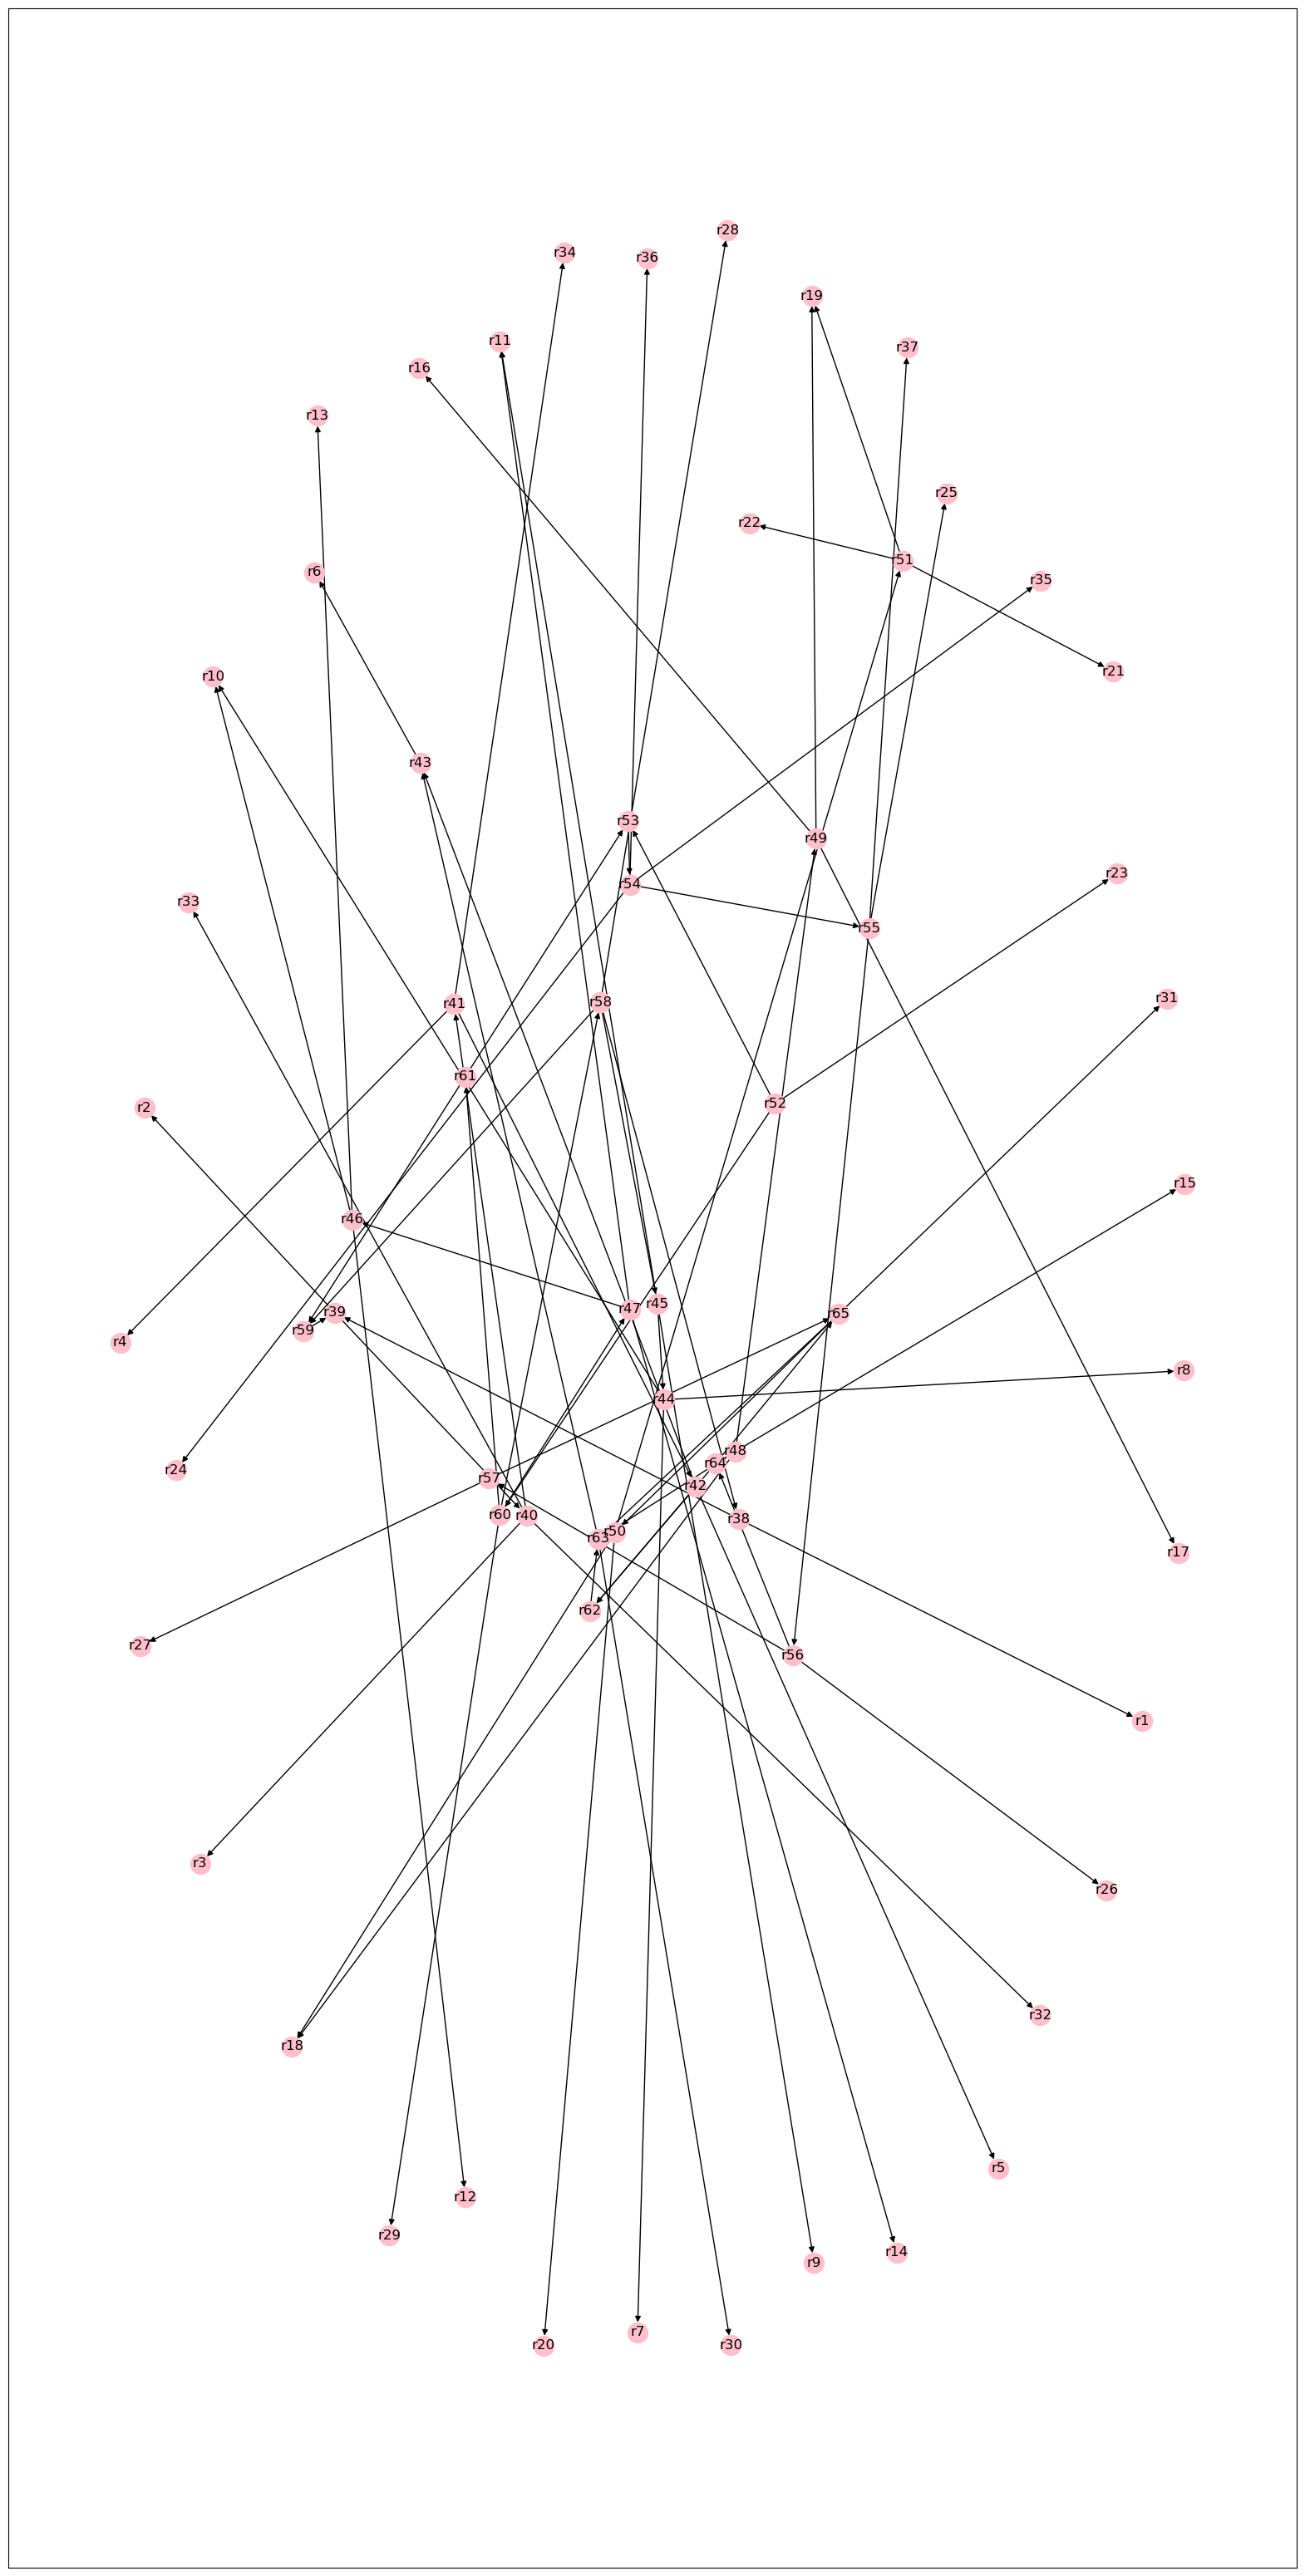

In [18]:
figures = []
plt.figure(figsize=(20,40))
G = nx.DiGraph()
G.add_edges_from(pair_of_smr)
nx.draw_networkx(G, arrows = True, node_color = 'pink')
figures.append(G)
plt.savefig('r.dag/0549(52).png')

## 2. <PyArgum 라이브러리를 이용한 동적 베이지안 네트워크 구현>

###   unStationary dBN (nsDBN)
 - DAG 유지, 확률변화 (CPT 변화 DBN만들기)

In [19]:
from datetime import datetime
now = datetime.now()

print("현재 : ", now)
print("현재 날짜 : ", now.date())
print("현재 시간 : ", now.time())
print("timestamp : ", now.timestamp())
print("년 : ", now.year)
print("월 : ", now.month)
print("일 : ", now.day)
print("시 : ", now.hour)
print("분 : ", now.minute)
print("초 : ", now.second)
print("마이크로초 : ", now.microsecond)
print("요일 : ", now.weekday())
print("문자열 변환 : ", now.strftime('%Y-%m-%d %H:%M:%S'))

현재 :  2023-11-23 18:43:36.725201
현재 날짜 :  2023-11-23
현재 시간 :  18:43:36.725201
timestamp :  1700732616.725201
년 :  2023
월 :  11
일 :  23
시 :  18
분 :  43
초 :  36
마이크로초 :  725201
요일 :  3
문자열 변환 :  2023-11-23 18:43:36


In [20]:
import pyAgrum as gum
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.lib.notebook as gnb

In [21]:
dag_dBN = gum.BayesNet('0549(52)')
dag_nodes = list(G.nodes)
dBN_nodes = []

for node in dag_nodes:
    globals()[node+'_0'] = dag_dBN.add(gum.LabelizedVariable(node+'_0',node+'_0',2))
    globals()[node+'_t'] = dag_dBN.add(gum.LabelizedVariable(node+'_t',node+'_t',2))
    dBN_nodes.append(node+'_0')
    dBN_nodes.append(node+'_t')
    
pair_of_self = [(node+'_0', node+'_t') for node in dag_nodes]
for link in pair_of_smr0:
    dag_dBN.addArc(*link)

print(dag_dBN)

for link in pair_of_smrt:
    dag_dBN.addArc(*link)

print(dag_dBN)

for link in pair_of_self:
    dag_dBN.addArc(*link)

BN{nodes: 130, arcs: 75, domainSize: 10^39.1339, dim: 216, mem: 3Ko 384o}
BN{nodes: 130, arcs: 150, domainSize: 10^39.1339, dim: 302, mem: 4Ko 736o}


In [22]:
dag_dBN.cpt('r1_0')

(pyAgrum.Potential<double>@0000026E6A8D53A0) 
      ||  r1_0             |
r38_0 ||0        |1        |
------||---------|---------|
0     || 0.0000  | 0.0000  |
1     || 0.0000  | 0.0000  |

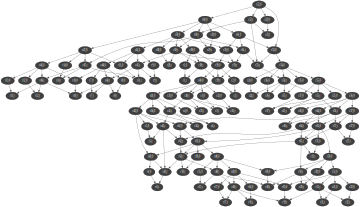

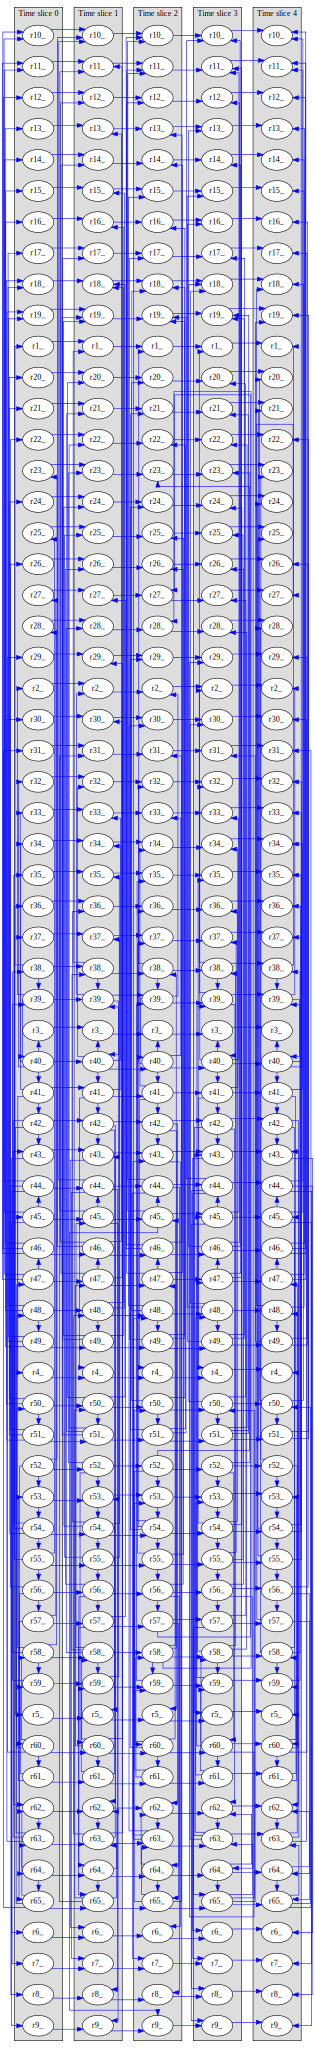

In [23]:
T = 5

gnb.showBN(dag_dBN)

ftts_dbn = gdyn.unroll2TBN(dag_dBN, T)
gdyn.showTimeSlices(ftts_dbn, size="30")

In [24]:
ftts_dbn_nodes = ftts_dbn.names()
ts_0 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) == 0)])
ts_1 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(1, 2))])
ts_2 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(2, 3))])
ts_3 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(3, 4))])
ts_4 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(4, 5))])

In [25]:
cpt_0 =[[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.2890,0.7110,0.2890,0.7110,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[1, 0],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.2232,0.7768,0.2232,0.7768,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.4863,0.5137,0.4863,0.5137,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000]]

cpt_1 = [[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4101,0.5899,0.0000,1.0000,0.4101,0.5899,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4170,0.5830,0.0000,1.0000,0.4170,0.5830,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4732,0.5268,0.0000,1.0000,0.4732,0.5268,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.7799,0.2201,0.0000,1.0000,0.7799,0.2201,0.0000,1.0000],[0.4468,0.5532,0.0000,1.0000,0.4468,0.5532,0.0000,1.0000],[0.4499,0.5501,0.0000,1.0000,0.4499,0.5501,0.0000,1.0000],[0.4299,0.5701,0.0000,1.0000,0.4299,0.5701,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4097,0.5903,0.0000,1.0000,0.4097,0.5903,0.0000,1.0000],[0.8689,0.1311,0.0000,1.0000,0.8689,0.1311,0.0000,1.0000],[0.4059,0.5941,0.0000,1.0000,0.4059,0.5941,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.5272,0.4728,0.0000,1.0000,0.5272,0.4728,0.0000,1.0000],[0.4080,0.5920,0.0000,1.0000,0.4080,0.5920,0.0000,1.0000],[0.4200,0.5800,0.0000,1.0000,0.4200,0.5800,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[1.0000,0.0000,0.4591,0.5409,0.5409,0.4591,0.0000,1.0000,1.0000,0.0000,0.4591,0.5409,0.5409,0.4591,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.5515,0.4485,0.0000,1.0000,0.5515,0.4485,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.5798,0.4202,0.0000,1.0000,0.5798,0.4202,0.0000,1.0000],[0.8371,0.1629,0.0000,1.0000,0.8371,0.1629,0.0000,1.0000],[0.7731,0.2269,0.0000,1.0000,0.7731,0.2269,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0100,0.9900,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.9912,0.0088,0.0000,1.0000,0.9912,0.0088,0.0000,1.0000],[0.7185,0.2815,0.0000,1.0000,0.7185,0.2815,0.0000,1.0000],[0.5976,0.4024,0.0000,1.0000,0.5976,0.4024,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.9650,0.0350,0.5975,0.4025,0.4025,0.5975,0.0000,1.0000,0.9650,0.0350,0.5975,0.4025,0.4025,0.5975,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4658,0.5342,0.0000,1.0000,0.4658,0.5342,0.0000,1.0000],[0.7538,0.2462,0.5818,0.4182,0.4182,0.5818,0.0000,1.0000,0.7538,0.2462,0.5818,0.4182,0.4182,0.5818,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000]]

cpt_2 = [[1.0000,0.0000,0.6049,0.3951,0.7269,0.2731,0.3318,0.6682,0.6682,0.3318,0.2731,0.7269,0.3951,0.6049,0.0000,1.0000],[1.0000,0.0000,0.6768,0.3232,0.6311,0.3689,0.3079,0.6921,0.6921,0.3079,0.3689,0.6311,0.3232,0.6768,0.0000,1.0000],[1.0000,0.0000,0.5432,0.4568,0.4568,0.5432,0.0000,1.0000],[1.0000,0.0000,0.6352,0.3648,0.3648,0.6352,0.0000,1.0000],[1.0000,0.0000,0.6112,0.3888,0.3888,0.6112,0.0000,1.0000],[0.3207,0.6793,0.0000,1.0000,0.3207,0.6793,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.5551,0.4449,0.4449,0.5551,0.0000,1.0000,1.0000,0.0000,0.5551,0.4449,0.4449,0.5551,0.0000,1.0000],[0.2442,0.7558,0.2442,0.7558,0.0000,1.0000,0.0000,1.0000,0.2442,0.7558,0.2442,0.7558,0.0000,1.0000,0.0000,1.0000],[1.0000,0.0000,0.5665,0.4335,0.4335,0.5665,0.0000,1.0000],[0.5690,0.4310,0.0000,1.0000,0.5690,0.4310,0.0000,1.0000],[0.5337,0.4663,0.0000,1.0000,0.5337,0.4663,0.0000,1.0000],[0.4658,0.5342,0.0000,1.0000,0.4658,0.5342,0.0000,1.0000],[1.0000,0.0000,0.7300,0.2700,0.2700,0.7300,0.0000,1.0000],[1.0000,0.0000,0.5730,0.4270,0.4270,0.5730,0.0000,1.0000],[1.0000,0.0000,0.5192,0.4808,0.4808,0.5192,0.0000,1.0000],[1.0000,0.0000,0.5026,0.4974,0.4974,0.5026,0.0000,1.0000],[0.7169,0.2831,0.0000,1.0000,0.7169,0.2831,0.0000,1.0000],[1.0000,0.0000,0.5285,0.4715,0.4715,0.5285,0.0000,1.0000],[1.0000,0.0000,0.6938,0.3062,0.3062,0.6938,0.0000,1.0000],[1.0000,0.0000,0.5553,0.4447,0.4447,0.5553,0.0000,1.0000],[0.4013,0.5987,0.0000,1.0000,0.4013,0.5987,0.0000,1.0000],[1.0000,0.0000,0.5265,0.4735,0.4735,0.5265,0.0000,1.0000],[0.6769,0.3231,0.0000,1.0000,0.6769,0.3231,0.0000,1.0000],[0.6120,0.3880,0.0000,1.0000,0.6120,0.3880,0.0000,1.0000],[0.5349,0.4651,0.0000,1.0000,0.5349,0.4651,0.0000,1.0000],[1.0000,0.0000,0.6357,0.3643,0.3643,0.6357,0.0000,1.0000],[1.0000,0.0000,0.6146,0.3854,0.3854,0.6146,0.0000,1.0000],[1.0000,0.0000,0.5298,0.4702,0.4702,0.5298,0.0000,1.0000],[1.0000,0.0000,0.5083,0.4917,0.4917,0.5083,0.0000,1.0000],[1.0000,0.0000,0.5093,0.4907,0.7334,0.2666,0.2427,0.7573,0.7573,0.2427,0.2666,0.7334,0.4907,0.5093,0.0000,1.0000],[0.6270,0.3730,0.0000,1.0000,0.6270,0.3730,0.0000,1.0000],[1.0000,0.0000,0.5916,0.4084,0.9707,0.0293,0.0000,1.0000],[0.7774,0.2226,0.0000,1.0000,0.7774,0.2226,0.0000,1.0000],[0.6183,0.3817,0.0000,1.0000,0.6183,0.3817,0.0000,1.0000],[1.0000,0.0000,0.6497,0.3503,0.3503,0.6497,0.0000,1.0000,0.7603,0.2397,0.6497,0.3503,0.3503,0.6497,0.0000,1.0000],[1.0000,0.0000,0.4769,0.5231,0.5231,0.4769,0.0000,1.0000],[1.0000,0.0000,0.9099,0.0901,0.0901,0.9099,0.0000,1.0000],[1.0000,0.0000,0.6204,0.3796,0.3796,0.6204,0.0000,1.0000],[1.0000,0.0000,0.7304,0.2696,0.2696,0.7304,0.0000,1.0000],[0.6857,0.3143,0.0000,1.0000,0.6857,0.3143,0.0000,1.0000],[0.4963,0.5037,0.0000,1.0000,0.4963,0.5037,0.0000,1.0000],[0.5691,0.4309,0.0000,1.0000,0.5691,0.4309,0.0000,1.0000],[0.8431,0.1569,0.0000,1.0000,0.8431,0.1569,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.6683,0.3317],[0.5000,0.5000,0.0000,1.0000],[1.0000,0.0000,0.4484,0.5516,0.9248,0.0752,0.3732,0.6268,0.6268,0.3732,0.0752,0.9248,0.5516,0.4484,0.0000,1.0000],[1.0000,0.0000,0.5899,0.4101,0.4101,0.5899,0.0000,1.0000],[1.0000,0.0000,0.4895,0.5105,0.5105,0.4895,0.0000,1.0000],[1.0000,0.0000,0.4350,0.5650,0.5650,0.4350,0.0000,1.0000],[1.0000,0.0000,0.3685,0.6315,0.6315,0.3685,0.0000,1.0000],[1.0000,0.0000,0.5918,0.4082,0.4082,0.5918,0.0000,1.0000],[1.0000,0.0000,0.6426,0.3574,0.7453,0.2547,0.3879,0.6121,0.6121,0.3879,0.2547,0.7453,0.3574,0.6426,0.0000,1.0000],[0.4522,0.5478,0.0000,1.0000,0.4522,0.5478,0.0000,1.0000],[1.0000,0.0000,0.7751,0.2249,0.2249,0.7751,0.0000,1.0000],[1.0000,0.0000,0.7123,0.2877,0.2877,0.7123,0.0000,1.0000],[0.9276,0.0724,0.4461,0.5539,0.5539,0.4461,0.0000,1.0000,0.9276,0.0724,0.4461,0.5539,0.5539,0.4461,0.0000,1.0000],[0.9645,0.0355,0.5122,0.4878,0.4878,0.5122,0.0000,1.0000,0.9645,0.0355,0.5122,0.4878,0.4878,0.5122,0.0000,1.0000],[1.0000,0.0000,0.5290,0.4710,0.4710,0.5290,0.0000,1.0000],[1.0000,0.0000,0.6488,0.3512,0.5895,0.4105,0.2383,0.7617,0.7617,0.2383,0.4105,0.5895,0.3512,0.6488,0.0000,1.0000],[0.4459,0.5541,0.0000,1.0000,0.4459,0.5541,0.0000,1.0000],[0.5805,0.4195,0.0000,1.0000,0.5805,0.4195,0.0000,1.0000],[0.5660,0.4340,0.0000,1.0000,0.5660,0.4340,0.0000,1.0000],[1.0000,0.0000,0.5525,0.4475,0.4475,0.5525,0.0000,1.0000]]

cpt_3 = [[1.0000,0.0000,0.7334,0.2666,0.7661,0.2339,0.4995,0.5005,0.5005,0.4995,0.2339,0.7661,0.2666,0.7334,0.0000,1.0000],[1.0000,0.0000,0.7449,0.2551,0.7296,0.2704,0.4745,0.5255,0.5255,0.4745,0.2704,0.7296,0.2551,0.7449,0.0000,1.0000],[1.0000,0.0000,0.7173,0.2827,0.2827,0.7173,0.0000,1.0000],[1.0000,0.0000,0.7448,0.2552,0.2552,0.7448,0.0000,1.0000],[1.0000,0.0000,0.7121,0.2879,0.2879,0.7121,0.0000,1.0000],[1.0000,0.0000,0.6217,0.3783,0.3783,0.6217,0.0000,1.0000],[0.5152,0.4848,0.0000,1.0000,0.5152,0.4848,0.0000,1.0000],[0.4102,0.5898,0.0000,1.0000,0.4102,0.5898,0.0000,1.0000],[1.0000,0.0000,0.7087,0.2913,0.6698,0.3302,0.3785,0.6215,0.6215,0.3785,0.3302,0.6698,0.2913,0.7087,0.0000,1.0000],[1.0000,0.0000,0.7072,0.2928,0.8084,0.1916,0.5156,0.4844,0.4844,0.5156,0.1916,0.8084,0.2928,0.7072,0.0000,1.0000],[1.0000,0.0000,0.7122,0.2878,0.2878,0.7122,0.0000,1.0000],[1.0000,0.0000,0.6152,0.3848,0.3848,0.6152,0.0000,1.0000],[1.0000,0.0000,0.6066,0.3934,0.3934,0.6066,0.0000,1.0000],[1.0000,0.0000,0.6082,0.3918,0.3918,0.6082,0.0000,1.0000],[1.0000,0.0000,0.6688,0.3312,0.3312,0.6688,0.0000,1.0000],[1.0000,0.0000,0.6893,0.3107,0.3107,0.6893,0.0000,1.0000],[1.0000,0.0000,0.6746,0.3254,0.3254,0.6746,0.0000,1.0000],[1.0000,0.0000,0.6748,0.3252,0.3252,0.6748,0.0000,1.0000],[1.0000,0.0000,0.6961,0.3039,0.3039,0.6961,0.0000,1.0000],[1.0000,0.0000,0.7176,0.2824,0.2824,0.7176,0.0000,1.0000],[1.0000,0.0000,0.6909,0.3091,0.3091,0.6909,0.0000,1.0000],[1.0000,0.0000,0.7168,0.2832,0.2832,0.7168,0.0000,1.0000],[1.0000,0.0000,0.6344,0.3656,0.3656,0.6344,0.0000,1.0000],[1.0000,0.0000,0.7345,0.2655,0.2655,0.7345,0.0000,1.0000],[1.0000,0.0000,0.6703,0.3297,0.3297,0.6703,0.0000,1.0000],[1.0000,0.0000,0.6626,0.3374,0.3374,0.6626,0.0000,1.0000],[1.0000,0.0000,0.6315,0.3685,0.3685,0.6315,0.0000,1.0000],[1.0000,0.0000,0.6951,0.3049,0.3049,0.6951,0.0000,1.0000],[1.0000,0.0000,0.7005,0.2995,0.2995,0.7005,0.0000,1.0000],[1.0000,0.0000,0.6869,0.3131,0.3131,0.6869,0.0000,1.0000],[1.0000,0.0000,0.5695,0.4305,0.4305,0.5695,0.0000,1.0000],[1.0000,0.0000,0.6776,0.3224,0.7346,0.2654,0.4123,0.5877,0.5877,0.4123,0.2654,0.7346,0.3224,0.6776,0.0000,1.0000],[1.0000,0.0000,0.6203,0.3797,0.3797,0.6203,0.0000,1.0000],[1.0000,0.0000,0.7720,0.2280,0.7280,0.2720,0.0000,1.0000],[1.0000,0.0000,0.5833,0.4167,0.4167,0.5833,0.0000,1.0000],[1.0000,0.0000,0.5589,0.4411,0.4411,0.5589,0.0000,1.0000],[1.0000,0.0000,0.7952,0.2048,0.6719,0.3281,0.4671,0.5329,0.5329,0.4671,0.3281,0.6719,0.2048,0.7952,0.0000,1.0000],[1.0000,0.0000,0.6396,0.3604,0.3604,0.6396,0.0000,1.0000],[1.0000,0.0000,0.6178,0.3822,0.3822,0.6178,0.0000,1.0000],[1.0000,0.0000,0.6720,0.3280,0.3280,0.6720,0.0000,1.0000],[1.0000,0.0000,0.6526,0.3474,0.3474,0.6526,0.0000,1.0000],[1.0000,0.0000,0.5359,0.4641,0.4641,0.5359,0.0000,1.0000],[1.0000,0.0000,0.5342,0.4658,0.4658,0.5342,0.0000,1.0000],[1.0000,0.0000,0.6394,0.3606,0.3606,0.6394,0.0000,1.0000],[1.0000,0.0000,0.6193,0.3807,0.3807,0.6193,0.0000,1.0000],[1.0000,0.0000,0.2097,0.7903,0.7903,0.2097,0.0000,1.0000],[0.6667,0.3333,0.0000,1.0000],[1.0000,0.0000,0.7115,0.2885,0.6733,0.3267,0.3847,0.6153,0.6153,0.3847,0.3267,0.6733,0.2885,0.7115,0.0000,1.0000],[1.0000,0.0000,0.5660,0.4340,0.4340,0.5660,0.0000,1.0000],[1.0000,0.0000,0.5660,0.4340,0.4340,0.5660,0.0000,1.0000],[1.0000,0.0000,0.5826,0.4174,0.4174,0.5826,0.0000,1.0000],[1.0000,0.0000,0.5695,0.4305,0.4305,0.5695,0.0000,1.0000],[1.0000,0.0000,0.5679,0.4321,0.4321,0.5679,0.0000,1.0000],[1.0000,0.0000,0.7193,0.2807,0.7561,0.2439,0.4755,0.5245,0.5245,0.4755,0.2439,0.7561,0.2807,0.7193,0.0000,1.0000],[1.0000,0.0000,0.6185,0.3815,0.3815,0.6185,0.0000,1.0000],[1.0000,0.0000,0.5626,0.4374,0.4374,0.5626,0.0000,1.0000],[1.0000,0.0000,0.5923,0.4077,0.4077,0.5923,0.0000,1.0000],[1.0000,0.0000,0.6607,0.3393,0.7908,0.2092,0.4515,0.5485,0.5485,0.4515,0.2092,0.7908,0.3393,0.6607,0.0000,1.0000],[1.0000,0.0000,0.6546,0.3454,0.7244,0.2756,0.3790,0.6210,0.6210,0.3790,0.2756,0.7244,0.3454,0.6546,0.0000,1.0000],[1.0000,0.0000,0.7003,0.2997,0.2997,0.7003,0.0000,1.0000],[1.0000,0.0000,0.7610,0.2390,0.6714,0.3286,0.4324,0.5676,0.5676,0.4324,0.3286,0.6714,0.2390,0.7610,0.0000,1.0000],[1.0000,0.0000,0.6135,0.3865,0.3865,0.6135,0.0000,1.0000],[1.0000,0.0000,0.6974,0.3026,0.3026,0.6974,0.0000,1.0000],[1.0000,0.0000,0.9694,0.0306,0.5306,0.4694,0.0000,1.0000],[1.0000,0.0000,0.7046,0.2954,0.2954,0.7046,0.0000,1.0000]]

cpt_4 = [[1.0000,0.0000,0.7108,0.2892,0.7463,0.2537,0.4571,0.5429,0.5429,0.4571,0.2537,0.7463,0.2892,0.7108,0.0000,1.0000],[1.0000,0.0000,0.7245,0.2755,0.7080,0.2920,0.4325,0.5675,0.5675,0.4325,0.2920,0.7080,0.2755,0.7245,0.0000,1.0000],[1.0000,0.0000,0.6816,0.3184,0.3184,0.6816,0.0000,1.0000],[1.0000,0.0000,0.7112,0.2888,0.2888,0.7112,0.0000,1.0000],[1.0000,0.0000,0.6760,0.3240,0.3240,0.6760,0.0000,1.0000],[1.0000,0.0000,0.7105,0.2895,0.2895,0.7105,0.0000,1.0000],[1.0000,0.0000,0.6766,0.3234,0.3234,0.6766,0.0000,1.0000],[1.0000,0.0000,0.7345,0.2655,0.2655,0.7345,0.0000,1.0000],[1.0000,0.0000,0.7492,0.2508,0.7156,0.2844,0.4648,0.5352,0.5352,0.4648,0.2844,0.7156,0.2508,0.7492,0.0000,1.0000],[1.0000,0.0000,0.7137,0.2863,0.8173,0.1827,0.5310,0.4690,0.4690,0.5310,0.1827,0.8173,0.2863,0.7137,0.0000,1.0000],[1.0000,0.0000,0.6761,0.3239,0.3239,0.6761,0.0000,1.0000],[1.0000,0.0000,0.6351,0.3649,0.3649,0.6351,0.0000,1.0000],[1.0000,0.0000,0.6406,0.3594,0.3594,0.6406,0.0000,1.0000],[1.0000,0.0000,0.6406,0.3594,0.3594,0.6406,0.0000,1.0000],[1.0000,0.0000,0.6301,0.3699,0.3699,0.6301,0.0000,1.0000],[1.0000,0.0000,0.6518,0.3482,0.3482,0.6518,0.0000,1.0000],[1.0000,0.0000,0.6363,0.3637,0.3637,0.6363,0.0000,1.0000],[1.0000,0.0000,0.6365,0.3635,0.3635,0.6365,0.0000,1.0000],[1.0000,0.0000,0.6612,0.3388,0.3388,0.6612,0.0000,1.0000],[1.0000,0.0000,0.6819,0.3181,0.3181,0.6819,0.0000,1.0000],[1.0000,0.0000,0.6535,0.3465,0.3465,0.6535,0.0000,1.0000],[1.0000,0.0000,0.6811,0.3189,0.3189,0.6811,0.0000,1.0000],[1.0000,0.0000,0.7021,0.2979,0.2979,0.7021,0.0000,1.0000],[1.0000,0.0000,0.7000,0.3000,0.3000,0.7000,0.0000,1.0000],[1.0000,0.0000,0.6515,0.3485,0.3485,0.6515,0.0000,1.0000],[1.0000,0.0000,0.6538,0.3462,0.3462,0.6538,0.0000,1.0000],[1.0000,0.0000,0.6528,0.3472,0.3472,0.6528,0.0000,1.0000],[1.0000,0.0000,0.6580,0.3420,0.3420,0.6580,0.0000,1.0000],[1.0000,0.0000,0.6636,0.3364,0.3364,0.6636,0.0000,1.0000],[1.0000,0.0000,0.6493,0.3507,0.3507,0.6493,0.0000,1.0000],[1.0000,0.0000,0.5275,0.4725,0.4725,0.5275,0.0000,1.0000],[1.0000,0.0000,0.6554,0.3446,0.7164,0.2836,0.3718,0.6282,0.6282,0.3718,0.2836,0.7164,0.3446,0.6554,0.0000,1.0000],[1.0000,0.0000,0.6328,0.3672,0.3672,0.6328,0.0000,1.0000],[1.0000,0.0000,0.6862,0.3138,0.6471,0.3529,0.0000,1.0000],[1.0000,0.0000,0.5781,0.4219,0.4219,0.5781,0.0000,1.0000],[1.0000,0.0000,0.5781,0.4219,0.4219,0.5781,0.0000,1.0000],[1.0000,0.0000,0.8062,0.1938,0.6896,0.3104,0.4959,0.5041,0.5041,0.4959,0.3104,0.6896,0.1938,0.8062,0.0000,1.0000],[1.0000,0.0000,0.5995,0.4005,0.4005,0.5995,0.0000,1.0000],[1.0000,0.0000,0.5770,0.4230,0.4230,0.5770,0.0000,1.0000],[1.0000,0.0000,0.6335,0.3665,0.3665,0.6335,0.0000,1.0000],[1.0000,0.0000,0.6131,0.3869,0.3869,0.6131,0.0000,1.0000],[1.0000,0.0000,0.5663,0.4337,0.4337,0.5663,0.0000,1.0000],[1.0000,0.0000,0.6163,0.3837,0.3837,0.6163,0.0000,1.0000],[1.0000,0.0000,0.6516,0.3484,0.3484,0.6516,0.0000,1.0000],[1.0000,0.0000,0.5904,0.4096,0.4096,0.5904,0.0000,1.0000],[1.0000,0.0000,0.4330,0.5670,0.5670,0.4330,0.0000,1.0000],[0.7500,0.2500,0.0000,1.0000],[1.0000,0.0000,0.6930,0.3070,0.6524,0.3476,0.3454,0.6546,0.6546,0.3454,0.3476,0.6524,0.3070,0.6930,0.0000,1.0000],[1.0000,0.0000,0.5239,0.4761,0.4761,0.5239,0.0000,1.0000],[1.0000,0.0000,0.5239,0.4761,0.4761,0.5239,0.0000,1.0000],[1.0000,0.0000,0.5408,0.4592,0.4592,0.5408,0.0000,1.0000],[1.0000,0.0000,0.5274,0.4726,0.4726,0.5274,0.0000,1.0000],[1.0000,0.0000,0.5258,0.4742,0.4742,0.5258,0.0000,1.0000],[1.0000,0.0000,0.6968,0.3032,0.7366,0.2634,0.4334,0.5666,0.5666,0.4334,0.2634,0.7366,0.3032,0.6968,0.0000,1.0000],[1.0000,0.0000,0.6781,0.3219,0.3219,0.6781,0.0000,1.0000],[1.0000,0.0000,0.5205,0.4795,0.4795,0.5205,0.0000,1.0000],[1.0000,0.0000,0.5507,0.4493,0.4493,0.5507,0.0000,1.0000],[1.0000,0.0000,0.6451,0.3549,0.7812,0.2188,0.4264,0.5736,0.5736,0.4264,0.2188,0.7812,0.3549,0.6451,0.0000,1.0000],[1.0000,0.0000,0.6529,0.3471,0.7231,0.2769,0.3760,0.6240,0.6240,0.3760,0.2769,0.7231,0.3471,0.6529,0.0000,1.0000],[1.0000,0.0000,0.6635,0.3365,0.3365,0.6635,0.0000,1.0000],[1.0000,0.0000,0.7437,0.2563,0.6476,0.3524,0.3913,0.6087,0.6087,0.3913,0.3524,0.6476,0.2563,0.7437,0.0000,1.0000],[1.0000,0.0000,0.6763,0.3237,0.3237,0.6763,0.0000,1.0000],[1.0000,0.0000,0.6891,0.3109,0.3109,0.6891,0.0000,1.0000],[1.0000,0.0000,0.8617,0.1383,0.4716,0.5284,0.0000,1.0000],[1.0000,0.0000,0.6681,0.3319,0.3319,0.6681,0.0000,1.0000]]


In [26]:
ftts_dbn.cpt('r36_0')

(pyAgrum.Potential<double>@0000026E6D2083D0) 
      ||  r36_0            |
r54_0 ||0        |1        |
------||---------|---------|
0     || 0.0000  | 0.0000  |
1     || 0.0000  | 0.0000  |

In [27]:
for i in range(len(ts_0)):
    ftts_dbn.cpt(ts_0[i]).fillWith(cpt_0[i])

In [28]:
for n in range(65):
    for i in range(1*n, 1*(n+1)):
        ftts_dbn.cpt(ts_1[i]).fillWith(cpt_1[n])
    for j in range(1*n, 1*(n+1)):
        ftts_dbn.cpt(ts_2[j]).fillWith(cpt_2[n])
        ftts_dbn.cpt(ts_3[j]).fillWith(cpt_3[n])
        ftts_dbn.cpt(ts_4[j]).fillWith(cpt_4[n])

In [29]:
ftts_dbn.cpt('r35_4')

(pyAgrum.Potential<double>@0000026E6D208570) 
             ||  r35_4            |
r54_4 |r35_3 ||0        |1        |
------|------||---------|---------|
0     |0     || 1.0000  | 0.0000  |
1     |0     || 0.6580  | 0.3420  |
0     |1     || 0.3420  | 0.6580  |
1     |1     || 0.0000  | 1.0000  |

In [30]:
il = gum.LazyPropagation(ftts_dbn)
iv = gum.VariableElimination(ftts_dbn)

In [31]:
iv.setEvidence({'r52_0':0, 'r52_1':0, 'r52_2':0, 'r52_3':0, 'r52_4':0})


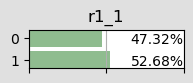
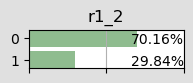
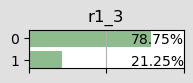
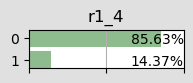
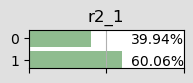
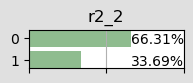
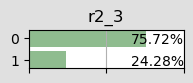
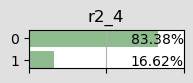
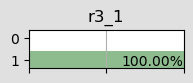
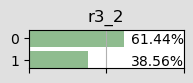
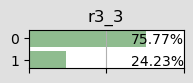
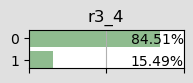
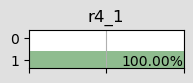
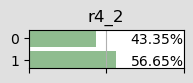
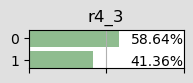
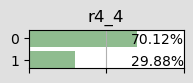
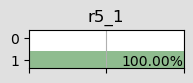
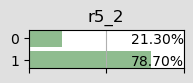
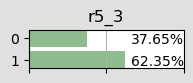
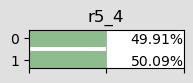
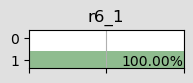
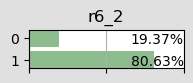
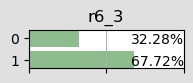
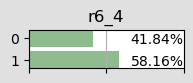
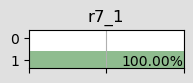
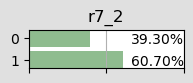
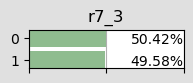
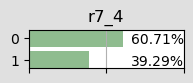
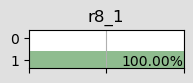
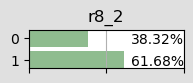
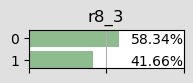
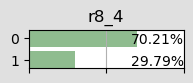
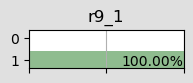
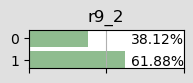
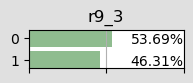
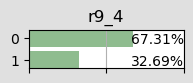
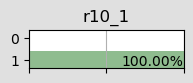
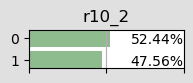
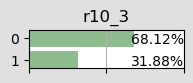
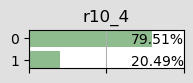
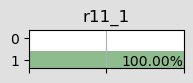
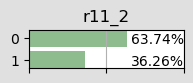
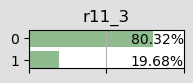
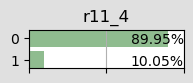
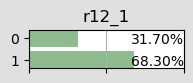
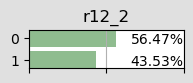
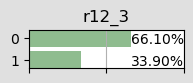
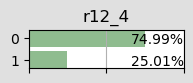
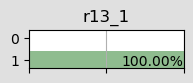
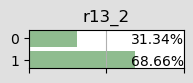
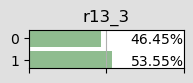
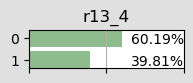
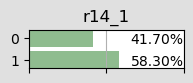
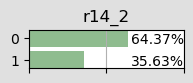
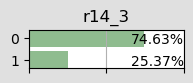
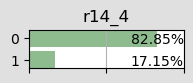
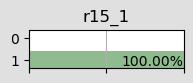
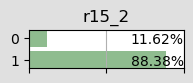
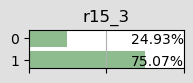
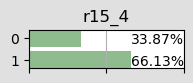
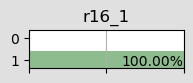
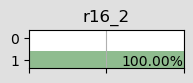
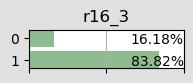
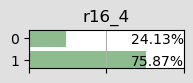
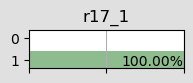
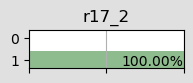
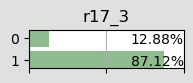
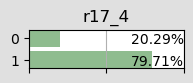
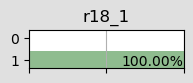
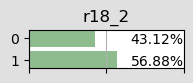
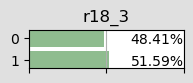
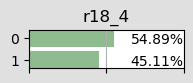
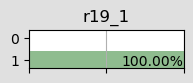
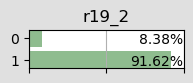
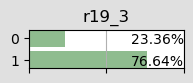
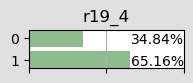
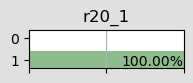
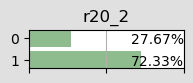
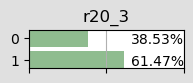
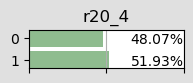
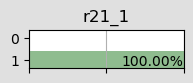
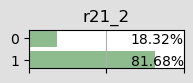
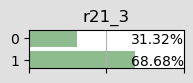
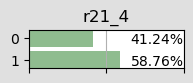
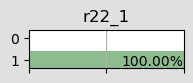
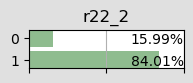
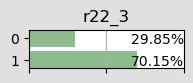
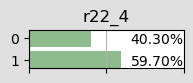
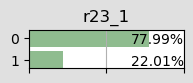
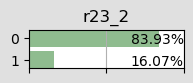
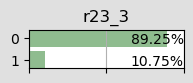
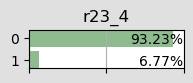
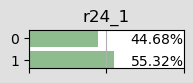
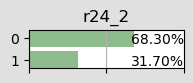
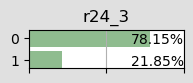
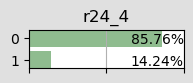
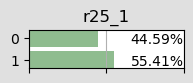
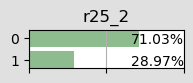
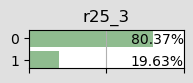
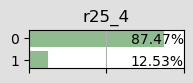
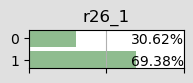
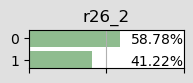
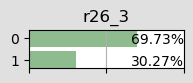
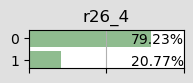
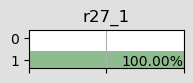
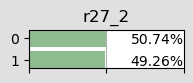
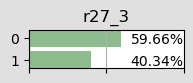
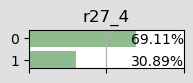
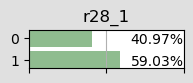
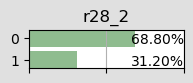
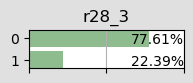
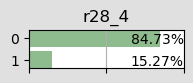
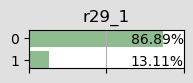
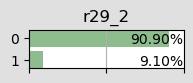
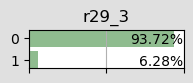
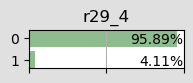
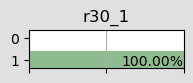
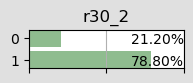
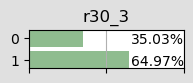
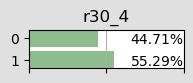
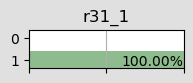
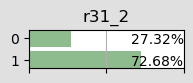
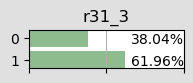
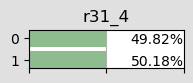
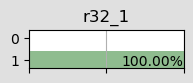
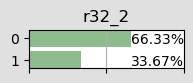
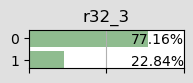
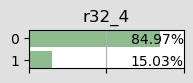
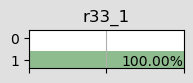
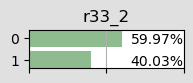
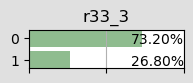
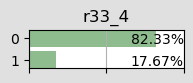
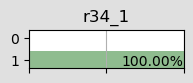
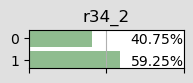
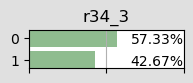
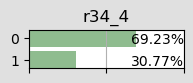
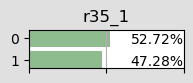
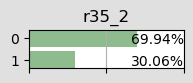
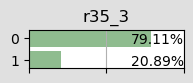
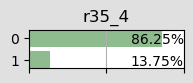
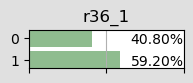
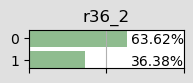
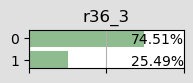
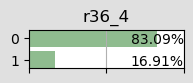
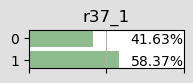
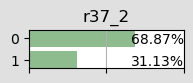
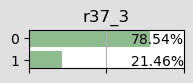
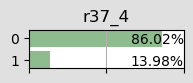
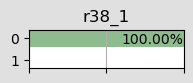
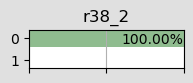
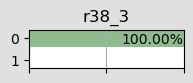
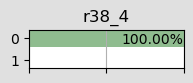
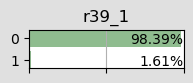
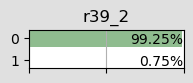
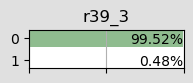
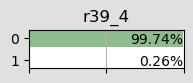
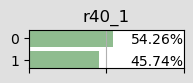
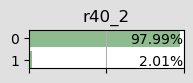
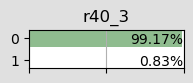
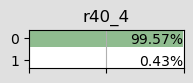
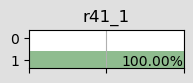
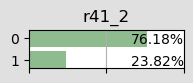
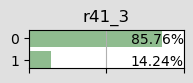
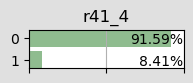
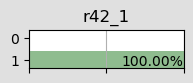
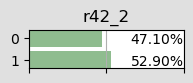
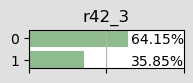
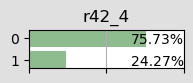
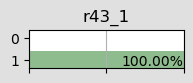
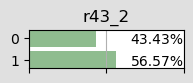
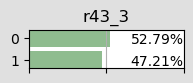
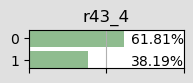
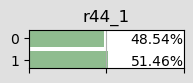
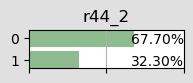
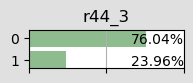
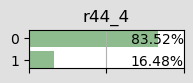
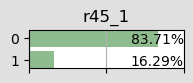
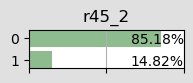
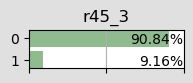
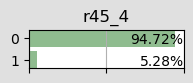
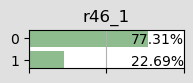
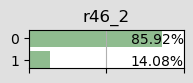
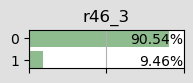
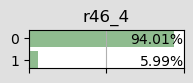
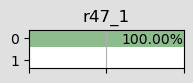
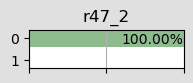
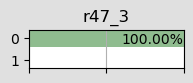
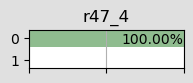
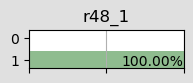
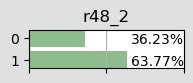
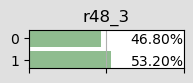
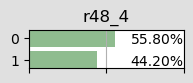
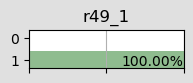
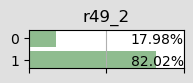
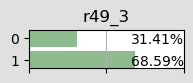
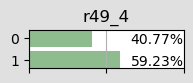
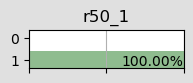
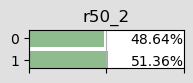
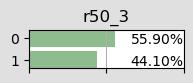
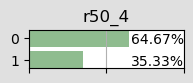
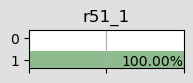
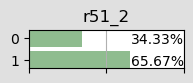
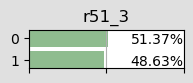
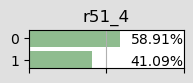
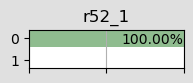
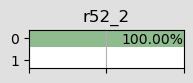
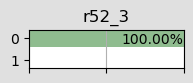
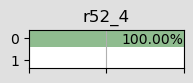
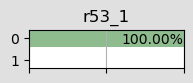
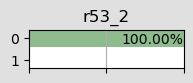
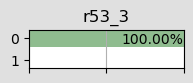
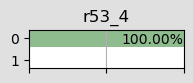
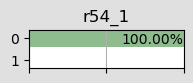
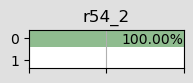
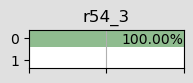
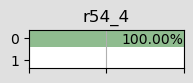
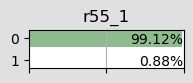
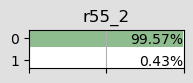
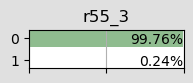
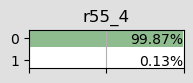
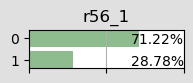
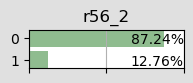
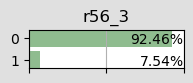
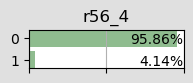
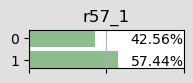
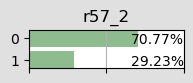
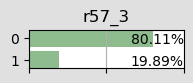
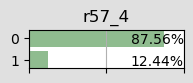
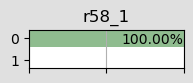
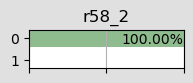
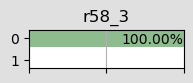
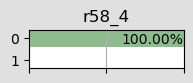
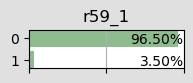
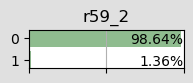
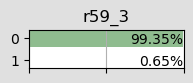
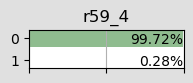
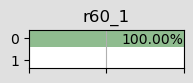
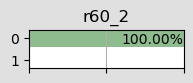
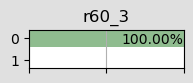
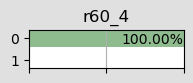
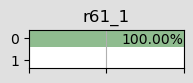
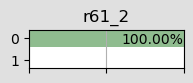
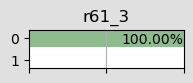
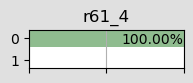
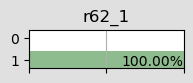
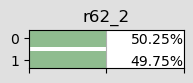
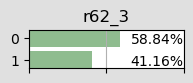
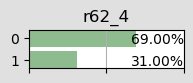
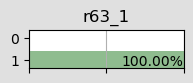
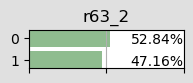
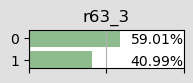
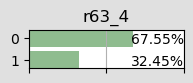
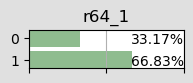
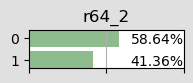
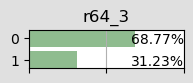
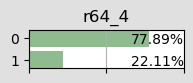
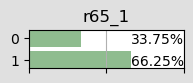
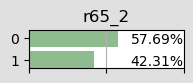
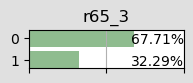
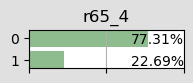

In [32]:
gnb.flow.clear()
for j in range(1,66):
    for i in [1, 2, 3, 4]:
        gnb.flow.add_html(gnb.getPosterior(ftts_dbn, target = "r"+str(j)+"_{}".format(i), evs={'r52_0':0, 'r52_1':0, 'r52_2':0, 'r52_3':0, 'r52_4':0}), "$P(a{})$".format(i))
gnb.flow.display()

In [33]:
now = datetime.now()

print("현재 : ", now)
print("현재 날짜 : ", now.date())
print("현재 시간 : ", now.time())
print("timestamp : ", now.timestamp())
print("년 : ", now.year)
print("월 : ", now.month)
print("일 : ", now.day)
print("시 : ", now.hour)
print("분 : ", now.minute)
print("초 : ", now.second)
print("마이크로초 : ", now.microsecond)
print("요일 : ", now.weekday())
print("문자열 변환 : ", now.strftime('%Y-%m-%d %H:%M:%S'))

현재 :  2023-11-23 18:43:50.337944
현재 날짜 :  2023-11-23
현재 시간 :  18:43:50.337944
timestamp :  1700732630.337944
년 :  2023
월 :  11
일 :  23
시 :  18
분 :  43
초 :  50
마이크로초 :  337944
요일 :  3
문자열 변환 :  2023-11-23 18:43:50


In [34]:
ftts_dbn_rooms =[e.split('_')[0]+('_') for e in ftts_dbn_nodes]

In [35]:
#plt.rcParams['figure.figsize'] = (10, 2)
#gdyn.plotFollowUnrolled(ftts_dbn_rooms,ftts_dbn,T=8,evs={'r52_0':0, 'r52_1':0, 'r52_2':0, 'r52_3':0, 'r52_4':0, 'r52_5':0, 'r52_6':0, 'r52_7':0 })

In [36]:
ftts_dbn.cpt('r29_0')

(pyAgrum.Potential<double>@0000026E6AE8A170) 
      ||  r29_0            |
r60_0 ||0        |1        |
------||---------|---------|
0     || 0.0000  | 1.0000  |
1     || 0.0000  | 1.0000  |

for node in dBN_nodes:
    dag_dBN.cpt(node)
    print(dag_dBN.cpt(node))

dag_dBN.cpt("r1_0").fillWith([0.74, 0.26, 0, 1])


dag_dBN.cpt("r53_0").names # 부모노드를 출력한다. 조건부확률의 조건


dag_dBN.cpt("r38_0").names


gnb.flow.clear()
for i in range(T):
    gnb.flow.add_html(gnb.getPosterior(unroll_dBN, target = "r1_{}".format(i), evs={}), "$P(a{})$".format(i))
gnb.flow.display()

sorted(ftts_dbn.names())